# Getting Under the Hood
In this example, we will explicitly write a model by subclassing the tf.keras.Model class and by writing a CustomDense layer. Although, the example is the same as the tf_keras_101_regression, a more detailed writing of the mechanism helps in realising what goes under the hood, up to a certain extent.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
import tensorflow as tf




2023-06-04 20:37:32.382645: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 20:37:32.418718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 20:37:32.419261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 20:37:35.515581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Subclassing keras.layers.Layer
In the following, we will write a custom dense layer by subclassing the keras.layers.Layer class. For a given input vector $\mathbf{x}$ it determines its dimensions $d_\mathbf{x}$ in the first call, and initializes a kernel matrix $\mathbf{W}$ and a bias $\mathbf{b}$. For a given number of nodes $N_{nodes}$, $\mathbf{W}$ is a $d_{\mathbf{x}}\times N_{nodes}$ dimensional matrix, while $\mathbf{b}$ is an $N_{nodes}$ dimensional vector. These two together make up the trainable parameters in a dense layer. For some given activation function $A$, we have the $N_{nodes}$ dimensional vector $\mathbf{y}$ of the form
\begin{equation}
\mathbf{y}=A(\, \mathbf{W}\,.\,\mathbf{x} +\mathbf{b}\,)\quad\quad (1),
\end{equation} where the function $A$ is a scalar function applied element-wise on the vector obtained in the argument. Before training, $\mathbf{W}$ and $\mathbf{b}$ are initialized to some random value and the choice of this random distribution affects the convergence of the neural network. By default, keras initializes them with the glorot uniform initializer \([Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a.html)\). The training objective pertains to finding a good minima in the weight space for the given training data by minimimizing a differentiable loss function via gradient-descent optimization. 

In [2]:
class CustomDense(Layer):
    def __init__(self,num_nodes,input_shape=None,activation='relu'):
        self.num_nodes=num_nodes
        if activation is None or activation=='linear':
            self.activation=None
        else:
            self.activation=getattr(tf.keras.activations,activation)
        
            
        super(CustomDense,self).__init__()
        if input_shape is not None:
            if type(input_shape)==int:
               self.build((Nonde,input_shape)) 
            elif len(input_shape)==1:
                self.build((None,input_shape[0]))
            else:
                self.build(input_shape)
    def build(self, input_shape):
        '''first call to network infers the input shape and initializes kernel and bias
        '''
        #initializes a tf.Variable object with default glorot_uniform
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]),self.num_nodes])
        self.bias = self.add_weight('bias',shape=[self.num_nodes])
    def call(self,input_tensor):
        x = tf.matmul(input_tensor,self.kernel) #
        x += self.bias 
        if self.activation is not None:
            x = self.activation(x)
        return x

## Subclassing keras.models.Model
We will use the CustomDense layer written above to create a subclass of keras.models.Model, and use it in the following training. Given an input vector $\mathbf{x}$, the output of the hidden layer $\mathbf{h}_1$ in analogy to Eq. 1 is  
\begin{equation}
\mathbf{h}_1=A(\, \mathbf{W}_1\,.\,\mathbf{x} +\mathbf{b}_1\,)
\end{equation} 
For any hidden layer $i$, we have $\mathbf{h}_i$ as 
\begin{equation}
\mathbf{h}_{i}=A(\, \mathbf{W}_i\,.\,\mathbf{h}_{i-1} +\mathbf{b}_i\,)
\end{equation} After $L$ hidden layers, we have the output as 
\begin{equation}
\mathbf{y}=A(\, \mathbf{W}_{L+1}\,.\,\mathbf{h}_L +\mathbf{b}_{L+1}\,)
\end{equation} If we write $\mathbf{h}_i=f_i(\Theta_i,\mathbf{h}_{i-1})$ with $\Theta_i$ denoting the particular weight space given by $\mathbf{W}_i$ and $\mathbf{b}_i$, we can write the whole network as
\begin{equation}
\mathbf{y} = f_{L+1}(\Theta_{L+1},f_L(\Theta_{L},f_{L-1}(\Theta_{L-1},f_{L-2}(\Theta_{L-2},....f_1(\Theta_1,\mathbf{x}))\quad.
\end{equation} From the form written above, one instantly recognises that for the feed-forward structure, the mathematical function obtained is in the form of successive functional compositions of the input vector $\mathbf{x}$ through to the output vector $\mathbf{y}$. During training, the data $\mathbf{x}$ and hence the hidden vectors $\mathbf{h}_i$ are taken to be fixed (although practically, one needs to take them in batches, the rationale is similar to solving the normal equations for least squares regression where we find the best fit values by defining the sum of residuals over all data points) and we differentiate with respect to the various weights $\Theta_i$. The functional composition is the origin of the back-propagation equation wherein, the gradients w.r.t $\Theta_i$ at each layer depends on the gradients of the next layer with respect to theta $\Theta_{i+1}$ due to the application of the chain rule. These dependence makes it efficient to calculate the gradients of each $\Theta_i$ as a backward pass starting from the output layer's gradients which are propagated at each layer till the input layer. During inference, the weights $\Theta_i$ are fixed and we study the function's dependence on $\mathbf{x}$.

In [3]:
class MyMLP(tf.keras.models.Model):
    def __init__(self,input_dim,hidden_dims,output_dim,hidden_activation='relu',output_activation=None):
        super(MyMLP,self).__init__()
        self.all_layers=[CustomDense(hidden_dims[0],input_shape=(1,),activation=hidden_activation)]
        for h in hidden_dims[1:]:
            self.all_layers.append(CustomDense(h,activation=hidden_activation))
        self.all_layers.append(CustomDense(output_dim,activation=output_activation))
    def call(self,x):
        for layer in self.all_layers:
            x = layer(x)
        return x      

In [4]:
x=np.linspace(-20,20,10000) 
y=x**4-300*x**2+np.random.normal(0,1000,*x.shape) 

## Data Visualization
We visualize a small subset of the data using matplotlib

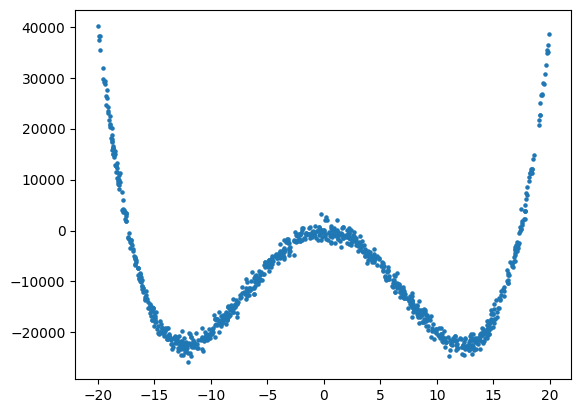

In [5]:
choice=np.random.randint(0,len(x),1000)
plt.scatter(x[choice],y[choice],s=5)

## Divide training and validation datasets
We divide the x and y value to training and validation datasets using numpy methods. 
It is also available in scikit-learn as [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 

In [6]:
x=np.expand_dims(x,1)
y=np.expand_dims(y,1)
all_inds=np.arange(len(x))
np.random.seed(145431)
np.random.shuffle(all_inds)
split_point=int(0.75*len(x))
x_train,y_train=x[all_inds[:split_point]],y[all_inds[:split_point]]
x_val,y_val=x[all_inds[split_point:]],y[all_inds[split_point:]]
print (x_train.shape,y_train.shape)
print (x_val.shape,y_val.shape)

(7500, 1) (7500, 1)
(2500, 1) (2500, 1)


## Create an instance of MyMLP

In [7]:
width=100
depth=3

model=MyMLP(1,[width for i in range(depth)],1)
model.build((None,1))
model.compile(loss="mean_squared_error",optimizer=keras.optimizers.Adam())
model.summary()

2023-06-04 20:38:16.739861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-04 20:38:16.747064: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "my_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_dense (CustomDense)  multiple                  200       
                                                                 
 custom_dense_1 (CustomDense  multiple                 10100     
 )                                                               
                                                                 
 custom_dense_2 (CustomDense  multiple                 10100     
 )                                                               
                                                                 
 custom_dense_3 (CustomDense  multiple                 101       
 )                                                               
                                                                 
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
________________________________________________________

## Training the model
We train the compiled model using the inbuilt fit method of keras models, and compare the predicted output of the network for each $n$ epochs. Note that we have used epoch=1 in the input to the fit method for ease of handling the plotting. For actual training purposes, the number of epochs should be directly fed into the fit method.

79/79 [==============================] - 0s 2ms/step
Epoch: 5


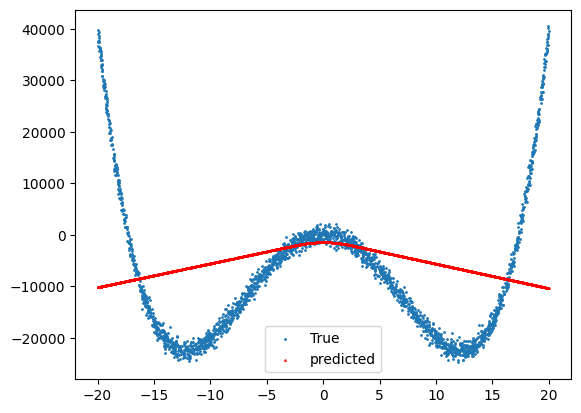

79/79 [==============================] - 0s 695us/step
Epoch: 10


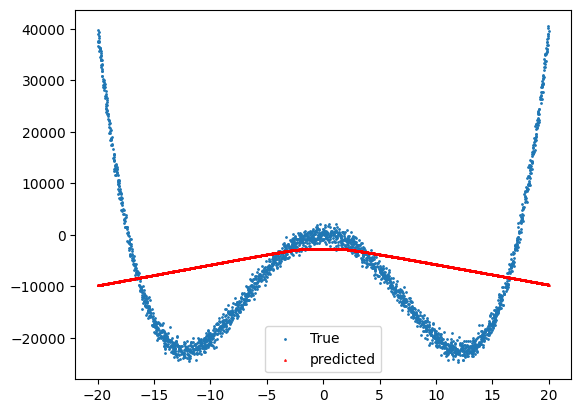

79/79 [==============================] - 0s 673us/step
Epoch: 15


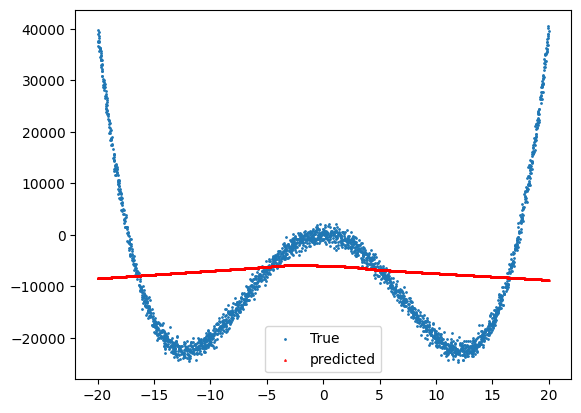

79/79 [==============================] - 0s 736us/step
Epoch: 20


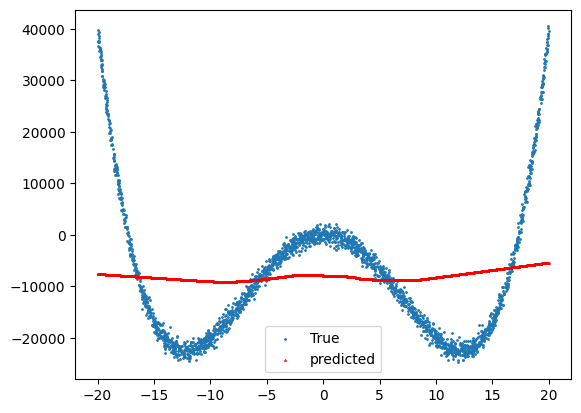

79/79 [==============================] - 0s 783us/step
Epoch: 25


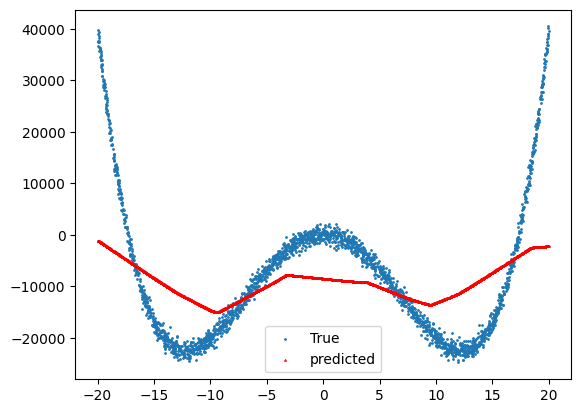

79/79 [==============================] - 0s 692us/step
Epoch: 30


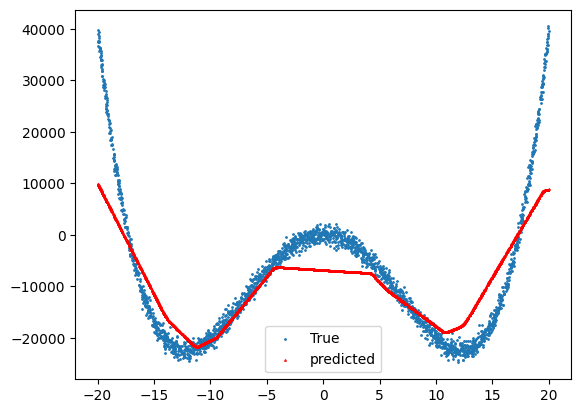

79/79 [==============================] - 0s 767us/step
Epoch: 35


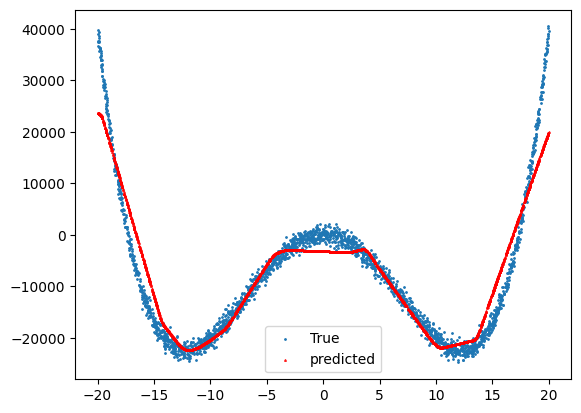

79/79 [==============================] - 0s 682us/step
Epoch: 40


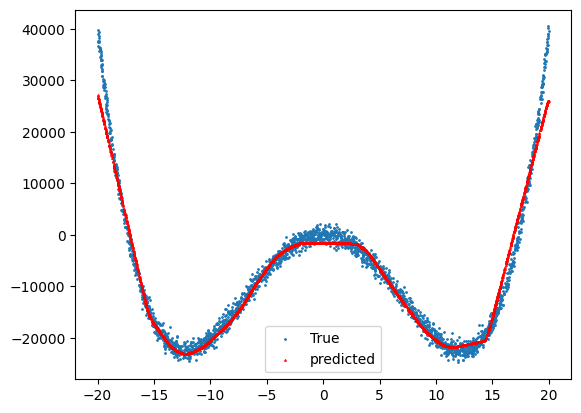

79/79 [==============================] - 0s 702us/step
Epoch: 45


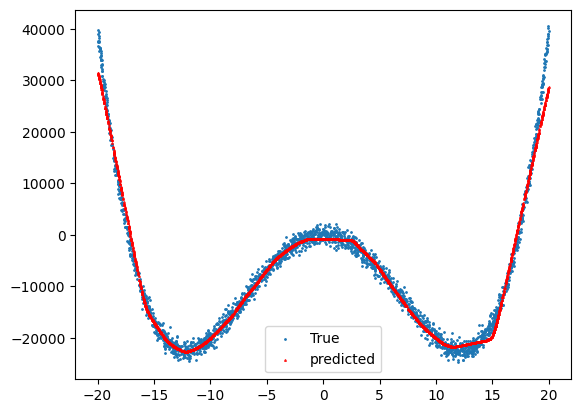

79/79 [==============================] - 0s 671us/step
Epoch: 50


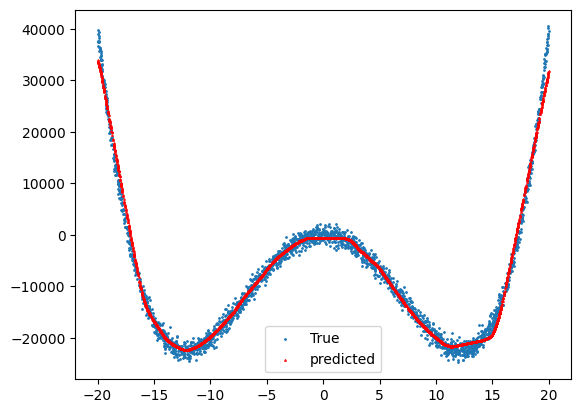

79/79 [==============================] - 0s 708us/step
Epoch: 55


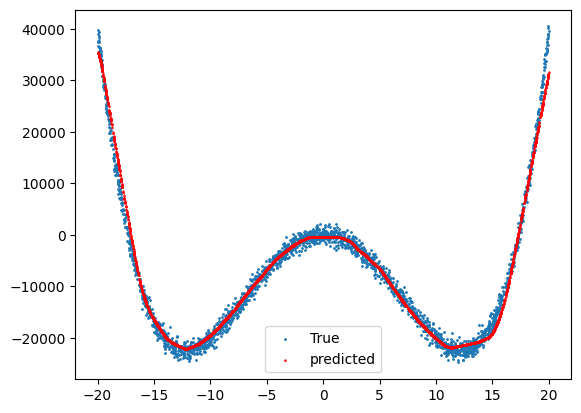

79/79 [==============================] - 0s 713us/step
Epoch: 60


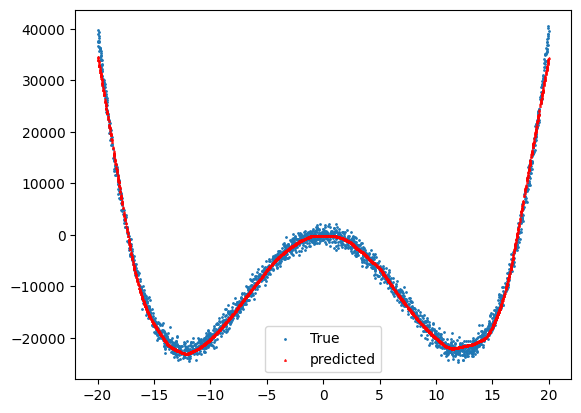

79/79 [==============================] - 0s 637us/step
Epoch: 65


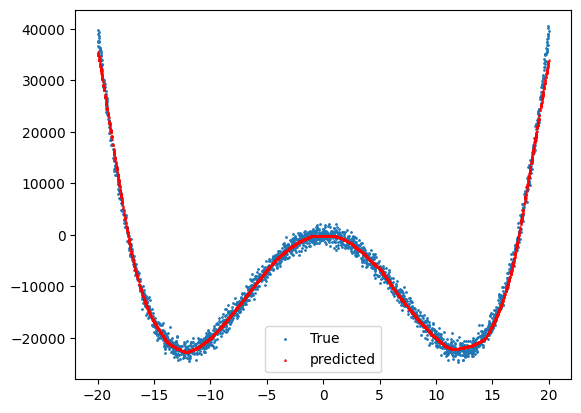

79/79 [==============================] - 0s 708us/step
Epoch: 70


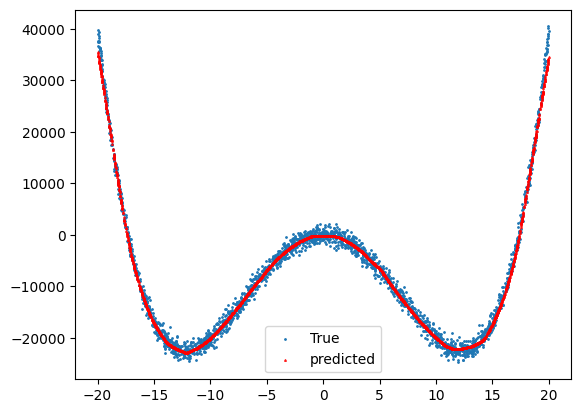

79/79 [==============================] - 0s 700us/step
Epoch: 75


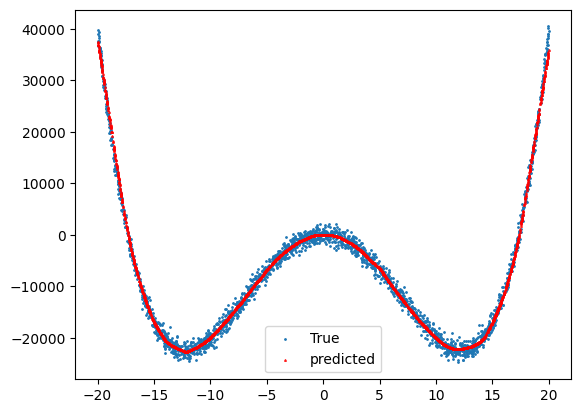

79/79 [==============================] - 0s 674us/step
Epoch: 80


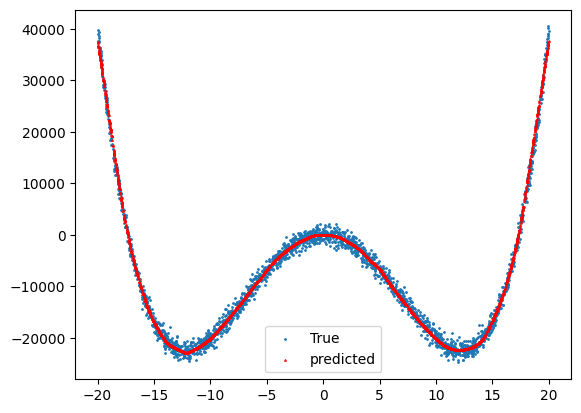

79/79 [==============================] - 0s 684us/step
Epoch: 85


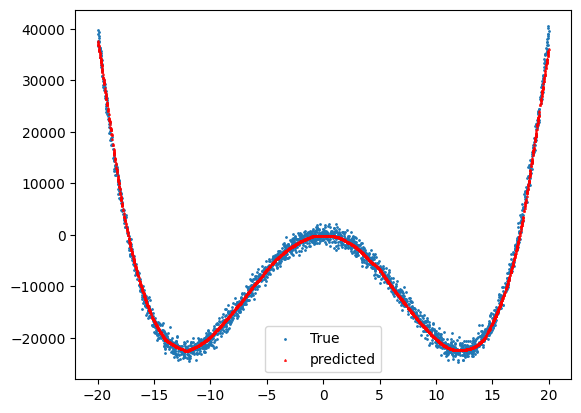

79/79 [==============================] - 0s 686us/step
Epoch: 90


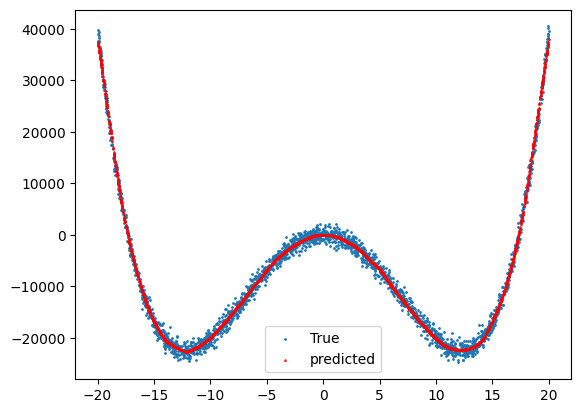

79/79 [==============================] - 0s 651us/step
Epoch: 95


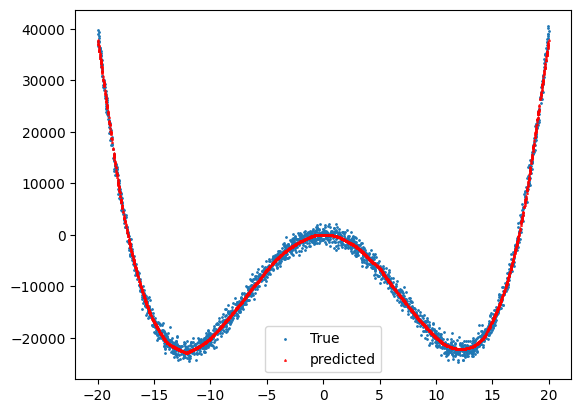

79/79 [==============================] - 0s 689us/step
Epoch: 100


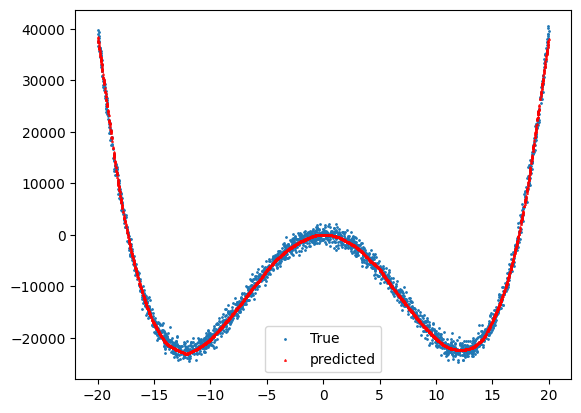

79/79 [==============================] - 0s 730us/step
Epoch: 105


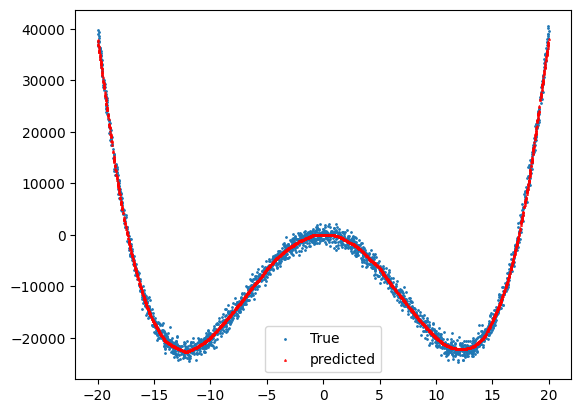

79/79 [==============================] - 0s 675us/step
Epoch: 110


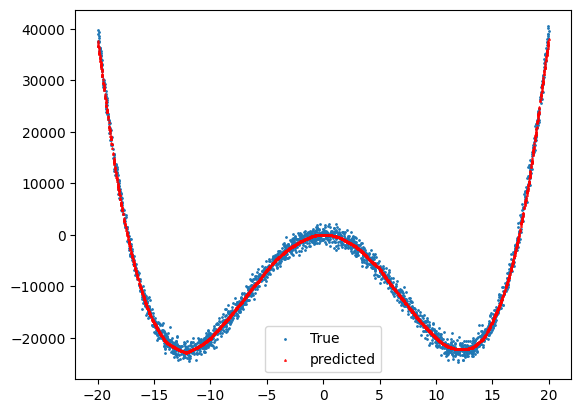

79/79 [==============================] - 0s 689us/step
Epoch: 115


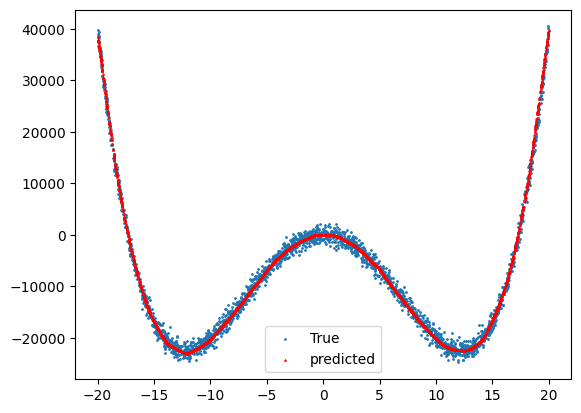

79/79 [==============================] - 0s 671us/step
Epoch: 120


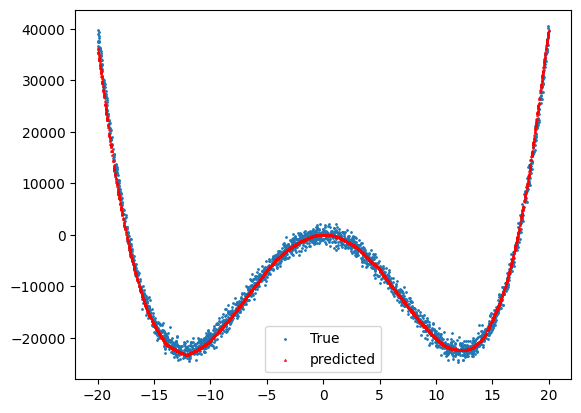

79/79 [==============================] - 0s 684us/step
Epoch: 125


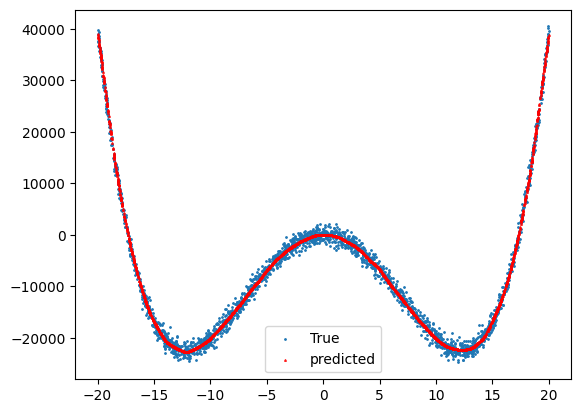

79/79 [==============================] - 0s 632us/step
Epoch: 130


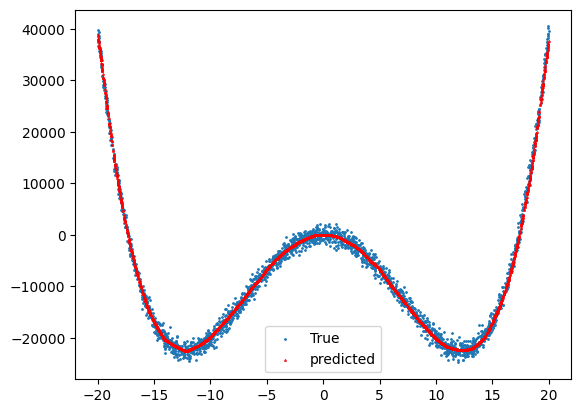

79/79 [==============================] - 0s 612us/step
Epoch: 135


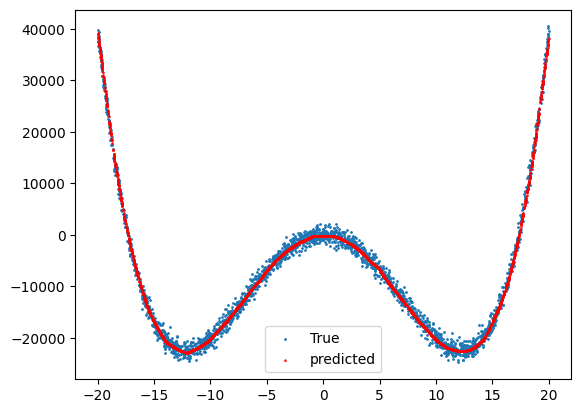

79/79 [==============================] - 0s 651us/step
Epoch: 140


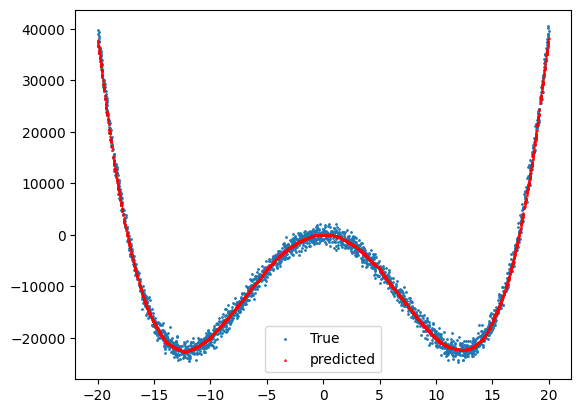

79/79 [==============================] - 0s 598us/step
Epoch: 145


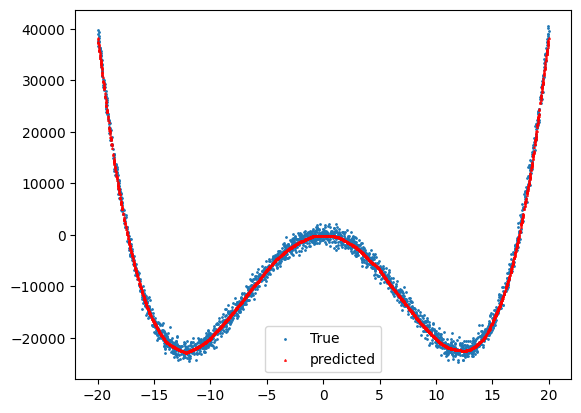

79/79 [==============================] - 0s 840us/step
Epoch: 150


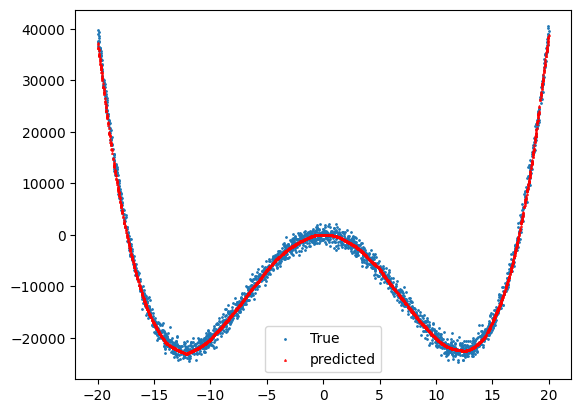

79/79 [==============================] - 0s 695us/step
Epoch: 155


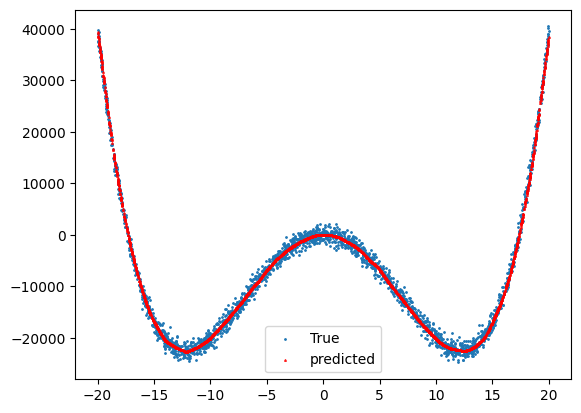

79/79 [==============================] - 0s 744us/step
Epoch: 160


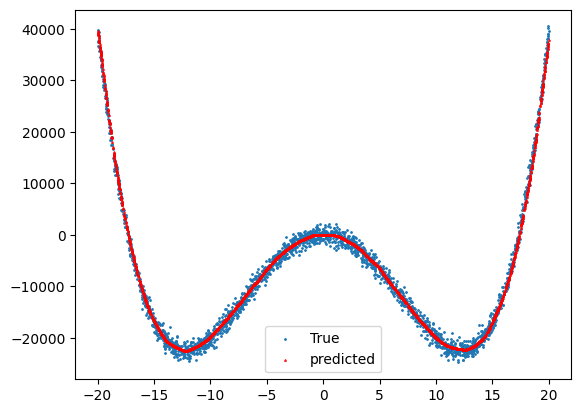

79/79 [==============================] - 0s 683us/step
Epoch: 165


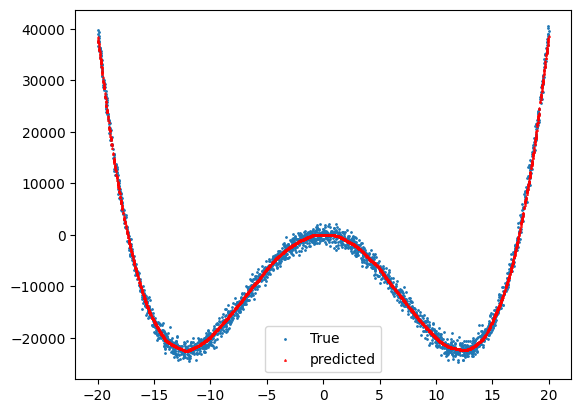

79/79 [==============================] - 0s 681us/step
Epoch: 170


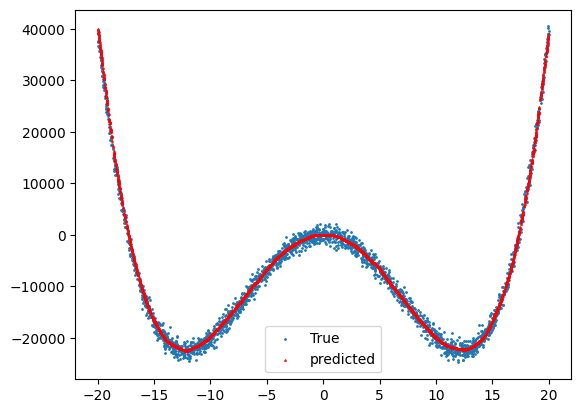

79/79 [==============================] - 0s 715us/step
Epoch: 175


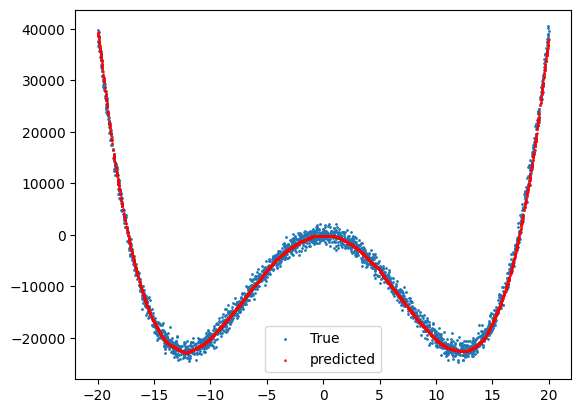

79/79 [==============================] - 0s 688us/step
Epoch: 180


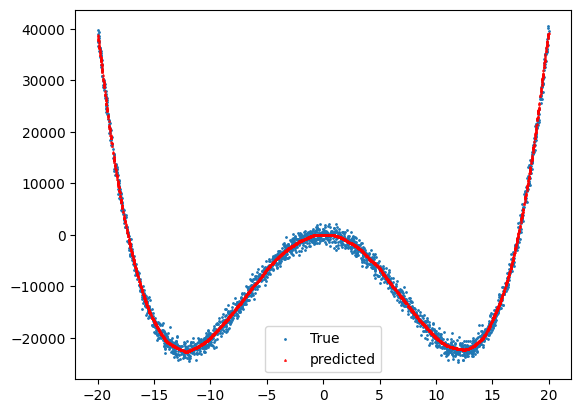

79/79 [==============================] - 0s 626us/step
Epoch: 185


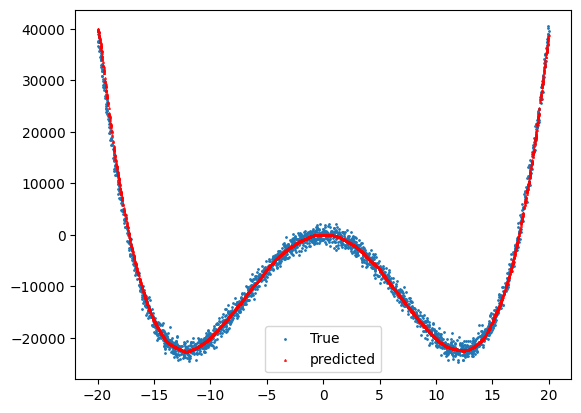

79/79 [==============================] - 0s 893us/step
Epoch: 190


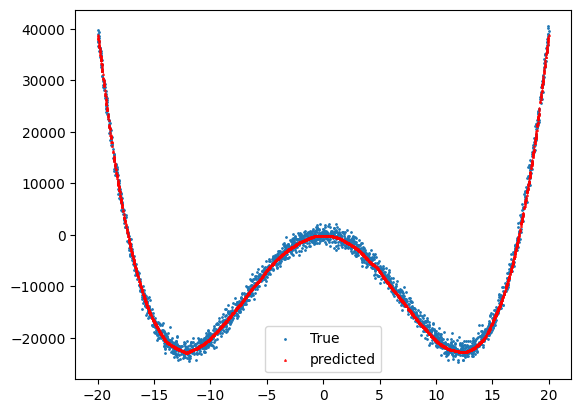

79/79 [==============================] - 0s 1ms/step
Epoch: 195


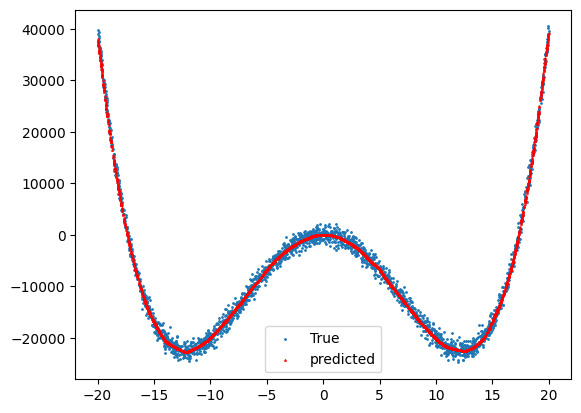

79/79 [==============================] - 0s 906us/step
Epoch: 200


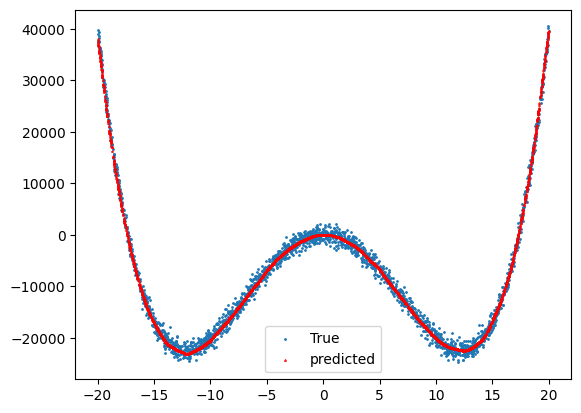

In [8]:
n=5
for _ in range(1,201):
  model.fit(x_train,y_train,epochs=1,batch_size=100,verbose=0,validation_data=(x_val,y_val))
  
  if _%n==0:
      y_val_pred=model.predict(x_val)
      print ("Epoch:",_)
      plt.scatter(x_val,y_val,marker="o",s=1,label="True")
      plt.scatter(x_val,y_val_pred,marker="^",c="r",s=1,label="predicted")
      plt.legend(loc="best")
      plt.show()